In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS

In [2]:
# Causal Inference for the Brave and True data
cibt_data_path = '../python-causality-handbook/causal-inference-for-the-brave-and-true/data'
# The Effect data
from causaldata import gov_transfers, mortgages


### Sharp RDs

#### Causal Inference for the Brave and True

In [3]:
df_drink = pd.read_csv(cibt_data_path+'/drinking.csv')
df_drink[["agecell", "all", "mva", "suicide"]].head()

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [4]:
df_drink['age_cent'] = df_drink['agecell'] - 21
df_drink['threshold'] = (df_drink['age_cent']>0).astype(int)

In [5]:
def poly(x, degree):
    return np.vander(x, degree + 1, increasing=True)[:, 1:] # powers start from 0
model_drink_ols = smf.ols(
    'all ~ poly(age_cent, 2) * threshold',
    data = df_drink
).fit()
df_drink['ols_values'] = model_drink_ols.fittedvalues
model_drink_ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.0729,1.404,66.301,0.000,90.240,95.906
"poly(age_cent, 2)[0]",-0.8306,3.290,-0.252,0.802,-7.470,5.809
"poly(age_cent, 2)[1]",-0.8403,1.615,-0.520,0.606,-4.100,2.419
threshold,9.5478,1.985,4.809,0.000,5.541,13.554
"poly(age_cent, 2)[0]:threshold",-6.0170,4.653,-1.293,0.203,-15.407,3.373
"poly(age_cent, 2)[1]:threshold",2.9042,2.284,1.271,0.211,-1.706,7.514


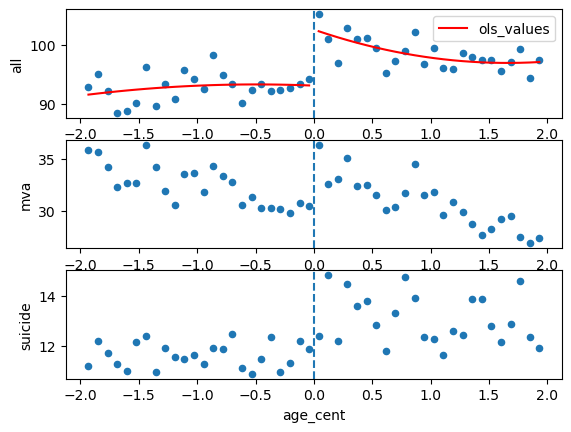

In [6]:
fig, ax = plt.subplots(3,1)
df_drink.plot.scatter('age_cent', 'all', ax=ax[0])
df_drink.plot.scatter('age_cent', 'mva', ax=ax[1])
df_drink.plot.scatter('age_cent', 'suicide', ax=ax[2])
df_drink.plot('age_cent', 'ols_values', ax=ax[0], color='red')
# the red line has a break because fittedvalues insert NaN when the outcome 
# variable is NaN for a data point.
for axs in ax:
    axs.axvline(x=0, linestyle='--')
plt.show()

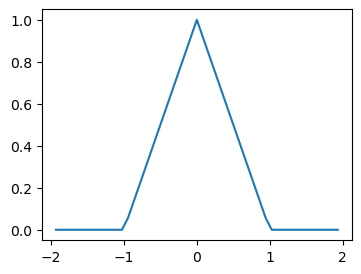

In [7]:
# local regression
def kernel(R, c, b):
    indicator = (np.abs(R-c)<=b).astype(float)
    return indicator * (1-np.abs(R-c)/b)

fig, ax = plt.subplots(figsize=(4,3))
plt.plot(df_drink['age_cent'], kernel(df_drink['age_cent'], c=0, b=1))
plt.show()

In [8]:
model_drink_wls = smf.wls(
    'all ~ poly(age_cent,1) * threshold',
    data = df_drink,
    weights=kernel(df_drink['age_cent'], c=0, b=0.5)
).fit()
df_drink['wls_values'] = model_drink_wls.fittedvalues
model_drink_wls.summary().tables[1]

/opt/homebrew/Caskroom/miniforge/base/envs/causal/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,94.2180,0.688,136.975,0.000,92.832,95.604
"poly(age_cent, 1)",5.6303,3.350,1.681,0.100,-1.121,12.382
threshold,9.5667,0.973,9.835,0.000,7.606,11.527
"poly(age_cent, 1):threshold",-17.4797,4.738,-3.690,0.001,-27.028,-7.932


(85.0, 110.0)

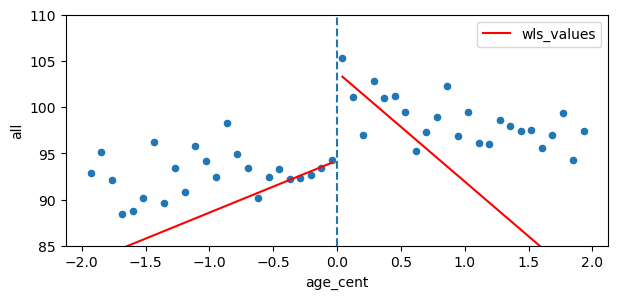

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,3))
df_drink.plot.scatter('age_cent', 'all', ax=ax)
df_drink.plot('age_cent', 'wls_values', ax=ax, color='red')
ax.axvline(x=0, linestyle='--')
ax.set_ylim(85,110)

#### The Effect

In [10]:
df_govt = gov_transfers.load_pandas().data
df_govt.head()

,Income_Centered,Education,Age,Participation,Support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0


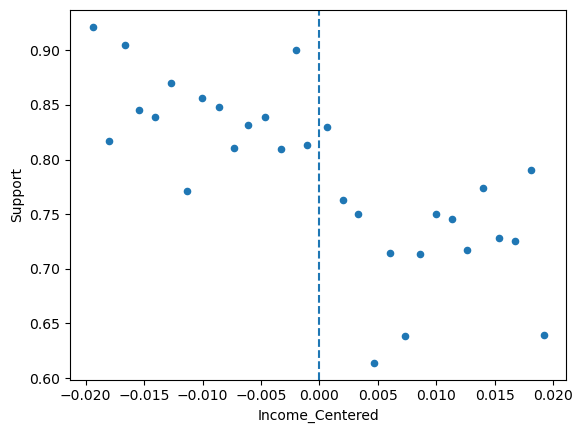

In [11]:
edges = np.linspace(-0.02, 0.02, 15*2+1)
df_govt['bins'] = pd.cut(df_govt['Income_Centered'], bins=edges)
binned_govt = df_govt.groupby('bins', observed=False).mean()
binned_govt.plot.scatter('Income_Centered', 'Support')
plt.axvline(x=0, linestyle='--')
plt.show()

In [12]:
model_govt_ols = smf.ols(
    'Support ~ poly(Income_Centered, 2)*Participation',
    df_govt
).fit(cov_type='HC3')
binned_govt['ols_values'] = model_govt_ols.predict(binned_govt[['Income_Centered','Participation']])
df_govt['ols_values'] = model_govt_ols.fittedvalues
model_govt_ols.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.7690,0.034,22.737,0.000,0.703,0.835
"poly(Income_Centered, 2)[0]",-11.5666,8.101,-1.428,0.153,-27.445,4.311
"poly(Income_Centered, 2)[1]",562.2473,401.982,1.399,0.162,-225.623,1350.117
Participation,0.0929,0.044,2.119,0.034,0.007,0.179
"poly(Income_Centered, 2)[0]:Participation",19.3000,10.322,1.870,0.062,-0.931,39.531
"poly(Income_Centered, 2)[1]:Participation",-101.1025,502.789,-0.201,0.841,-1086.551,884.346


In [13]:
model_govt_wls = smf.wls(
    'Support ~ poly(Income_Centered,1) * Participation',
    data = df_govt,
    weights=kernel(df_govt['Income_Centered'], c=0, b=0.01)
).fit()
binned_govt['wls_values'] = model_govt_wls.predict(binned_govt[['Income_Centered','Participation']])
df_govt['wls_values'] = model_govt_wls.fittedvalues
model_govt_wls.summary().tables[1]

/opt/homebrew/Caskroom/miniforge/base/envs/causal/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8194,0.019,43.280,0.000,0.782,0.857
"poly(Income_Centered, 1)",-23.6967,4.455,-5.320,0.000,-32.433,-14.960
Participation,0.0335,0.026,1.292,0.196,-0.017,0.084
"poly(Income_Centered, 1):Participation",26.5937,6.177,4.305,0.000,14.480,38.708


In [14]:
# Add a gap in the binned dataframe to get a gap in the trendline (for nice looking charts)
new_idx = np.append(binned_govt['Income_Centered'].values,[-0.00001, 0.00001])
binned_govt = binned_govt.set_index('Income_Centered').reindex(new_idx).reset_index().sort_values('Income_Centered')

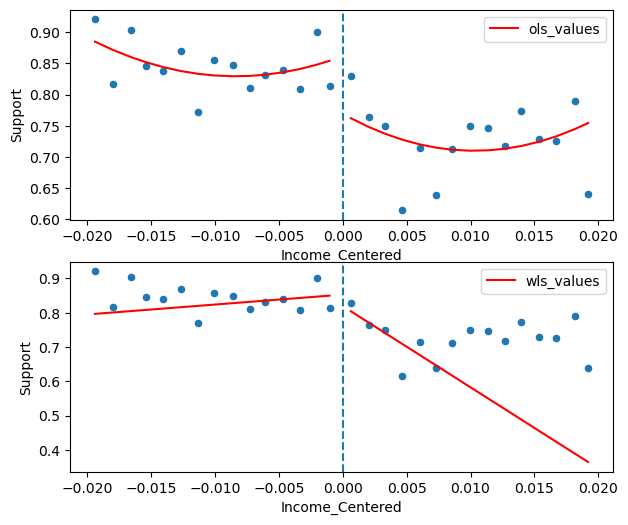

In [15]:
fig, ax = plt.subplots(2,1, figsize=(7,6))
binned_govt.plot('Income_Centered', 'ols_values', ax=ax[0], color='red')
binned_govt.plot('Income_Centered', 'wls_values', ax=ax[1], color='red')

for axs in ax:
    binned_govt.plot.scatter('Income_Centered', 'Support', ax=axs)
    axs.axvline(x=0, linestyle='--')

/opt/homebrew/Caskroom/miniforge/base/envs/causal/lib/python3.12/site-packages/binsreg/binsreg.py:1519: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


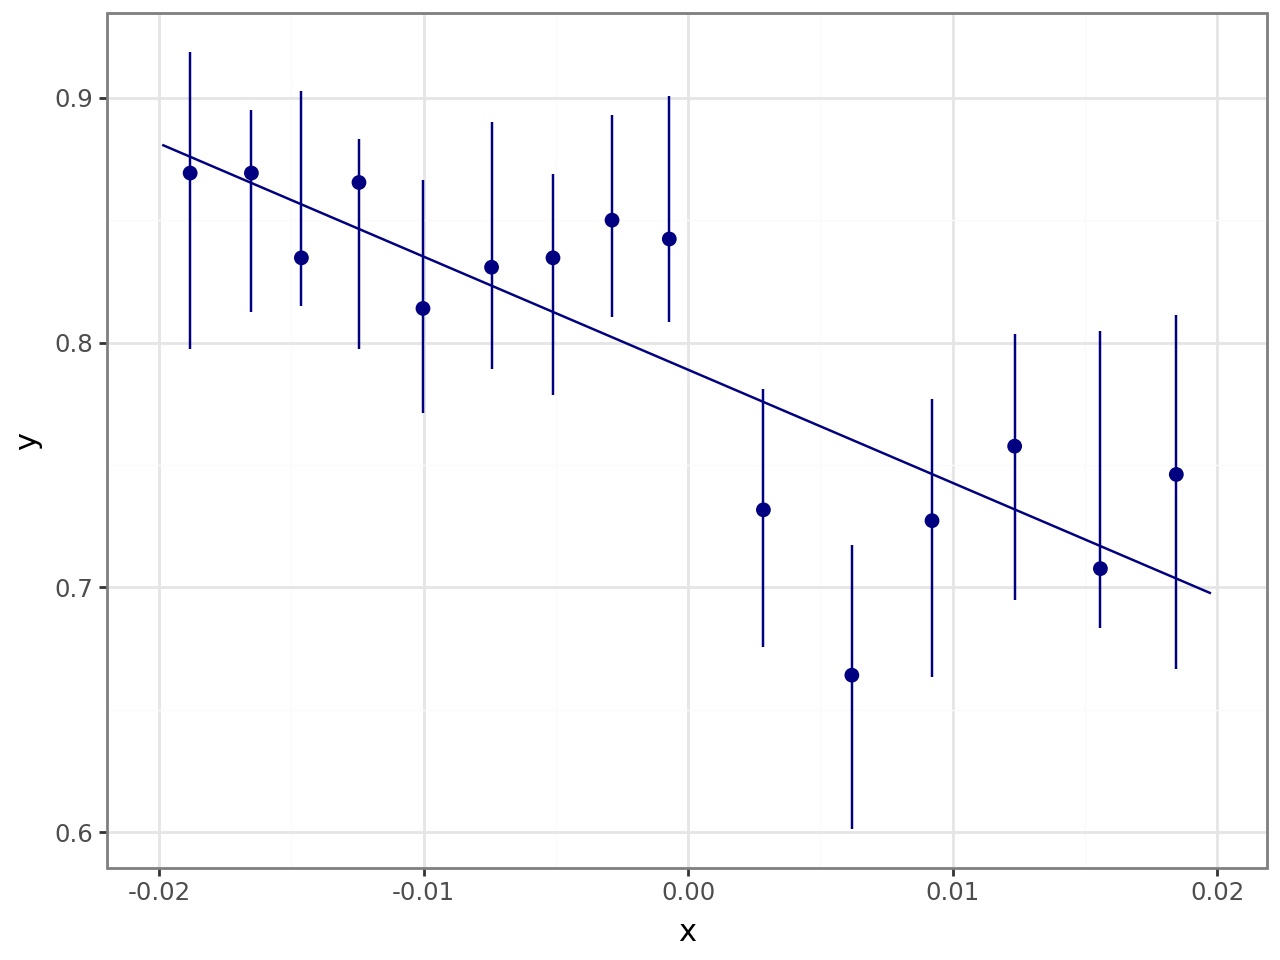

In [214]:
import binsreg
est = binsreg.binsreg(y=df_govt.Support.values, x=df_govt.Income_Centered.values, polyreg=1, ci=(3,3))
plt.show()

### Fuzzy RDs

#### Causal Inference for the Brave and True

In [140]:
df_sheepskin = pd.read_csv(cibt_data_path+'/sheepskin.csv')[['avgearnings', 'minscore', 'receivehsd', 'n']]
df_sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


In [141]:
# Disregarding non-compliance
df_sheepskin['threshold'] = (df_sheepskin['minscore']>0).astype(int)
model_sheepskin_wls = smf.wls(
    'avgearnings ~ minscore * threshold',
    df_sheepskin,
    weights=kernel(df_sheepskin['minscore'], c=0, b=15) * df_sheepskin['n'] # n is cell size
).fit()
df_sheepskin['wls_values'] = model_sheepskin_wls.fittedvalues
model_sheepskin_wls.summary().tables[1]

/opt/homebrew/Caskroom/miniforge/base/envs/causal/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


<Axes: xlabel='minscore', ylabel='avgearnings'>

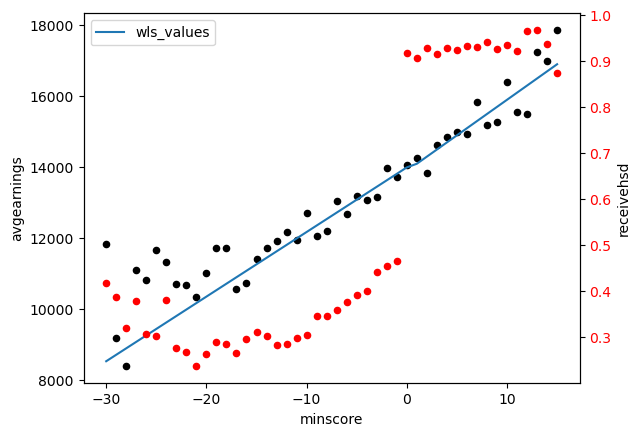

In [142]:
fig, ax = plt.subplots()
df_sheepskin.plot.scatter('minscore', 'avgearnings', ax=ax, color='black')
ax1 = ax.twinx()
df_sheepskin.plot.scatter('minscore', 'receivehsd', ax=ax1, color='red')
ax1.tick_params(axis='y', labelcolor='red')
df_sheepskin.plot('minscore', 'wls_values', ax=ax)

In [143]:
# Use the Wald estimator here
def wald_rdd(
        data: pd.DataFrame, 
        y: str, t: str,
        r: str, c: str,
        weights=1):
    # Numerator is calculated the same way as before
    numerator = smf.wls(
        y + '~' + r + '*' + c,
        data,
        weights=weights
    ).fit()
    # Denominator is the weighted regression of probability
    denominator = smf.wls(
        t + '~' + r + '*' + c,
        data,
        weights=weights
    ).fit()
    return numerator.params['threshold']/denominator.params['threshold']

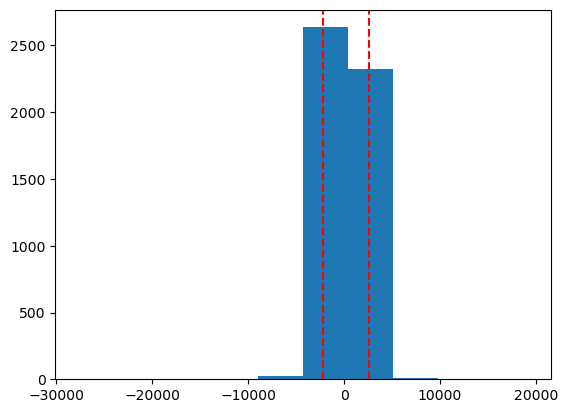

In [144]:
# Bootstrapping to get ate CI
ates = [
    wald_rdd(
        df_sheepskin.sample(frac=1, replace=True), 
        y='avgearnings', t='receivehsd', r='minscore', c='threshold',
        weights=kernel(df_sheepskin['minscore'], c=0, b=15) * df_sheepskin['n']
    ) 
    for _ in range(5000)
]
fig, ax = plt.subplots()
ax.hist(ates)
ax.axvline(np.percentile(ates,2.5),linestyle='--', color='red')
ax.axvline(np.percentile(ates,97.5),linestyle='--', color='red')

In [215]:
controls = df_sheepskin[['minscore']].assign(intercept=1)
# we need interactions for the second stage
df_sheepskin['interaction_hsd'] = df_sheepskin['receivehsd']*df_sheepskin['minscore']
# and the first
df_sheepskin['interaction_threshold'] = df_sheepskin['threshold']*df_sheepskin['minscore']

In [246]:
# Using 2sls (first the incorrect version which gives wrong standard errors but correct estimates)
first_stage = IV2SLS.from_formula(
    'receivehsd ~ minscore*threshold',
    df_sheepskin,
    weights=kernel(df_sheepskin['minscore'], c=0, b=15) * df_sheepskin['n']+0.0000001 # n is cell size
).fit()

IV2SLS.from_formula(
    'avgearnings ~ first_stage_receivehsd * minscore',
    df_sheepskin.assign(
        first_stage_receivehsd = first_stage.fitted_values
    ),
    weights=kernel(df_sheepskin['minscore'], c=0, b=15) * df_sheepskin['n']+0.0000001 # n is cell size
).fit()

OLS Estimation Summary                            
==============================================================================
Dep. Variable:            avgearnings   R-squared:                      0.9155
Estimator:                        OLS   Adj. R-squared:                 0.9095
No. Observations:                  46   F-statistic:                    369.68
Date:                Sun, Mar 03 2024   P-value (F-stat)                0.0000
Time:                        17:52:28   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                        Parameter Estimates                                        
===================================================================================================
                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------------
Intercept                        1.418e+04     550.15     25.781     0.0000   1.311e+04   1.526e+04
first_stage_receivehsd             -328.34     797.33    -0.4118     0.6805     -1891.1      1234.4
minscore                            184.35     44.977     4.0988     0.0000      96.198      272.50
first_stage_receivehsd:minscore     22.081     40.552     0.5445     0.5861     -57.399      101.56
===================================================================================================
OLSResults, id: 0x285a1a240

In [249]:
# The correct 2sls?
IV2SLS(
    df_sheepskin['avgearnings'],
    controls,
    df_sheepskin[['receivehsd', 'interaction_hsd']],
    df_sheepskin[['threshold', 'interaction_threshold']]
).fit()

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            avgearnings   R-squared:                      0.9004
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8933
No. Observations:                  46   F-statistic:                    464.42
Date:                Sun, Mar 03 2024   P-value (F-stat)                0.0000
Time:                        17:52:47   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
minscore            57.549     37.764     1.5239     0.1275     -16.468      131.57
intercept        1.339e+04     452.28     29.603     0.0000    1.25e+04   1.428e+04
receivehsd          361.93     606.66     0.5966     0.5508     -827.10      1551.0
interaction_hsd     183.22     62.574     2.9281     0.0034      60.578      305.86
===================================================================================

Endogenous: receivehsd, interaction_hsd
Instruments: threshold, interaction_threshold
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x284c57f50

In [250]:
# Formula api
IV2SLS.from_formula(
    'avgearnings ~ 1 + minscore + [receivehsd + interaction_hsd ~ threshold + interaction_threshold]',
    df_sheepskin
).fit()

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            avgearnings   R-squared:                      0.9004
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8933
No. Observations:                  46   F-statistic:                    464.42
Date:                Sun, Mar 03 2024   P-value (F-stat)                0.0000
Time:                        17:52:47   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept        1.339e+04     452.28     29.603     0.0000    1.25e+04   1.428e+04
minscore            57.549     37.764     1.5239     0.1275     -16.468      131.57
receivehsd          361.93     606.66     0.5966     0.5508     -827.10      1551.0
interaction_hsd     183.22     62.574     2.9281     0.0034      60.578      305.86
===================================================================================

Endogenous: receivehsd, interaction_hsd
Instruments: threshold, interaction_threshold
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x285a4eff0

#### The Effect

In [309]:
df_mortgages = mortgages.load_pandas().data
df_mortgages.head()

df_mortgages = df_mortgages.query('abs(qob_minus_kw)<8')

/var/folders/gr/nm48qff13zb7bpcknl4m0gmc0000gn/T/ipykernel_64111/428465761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/gr/nm48qff13zb7bpcknl4m0gmc0000gn/T/ipykernel_64111/428465761.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


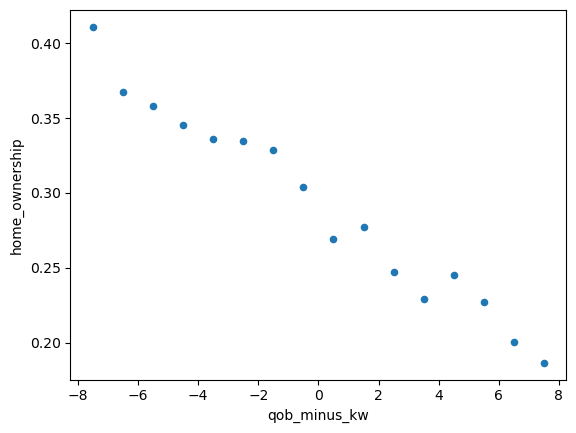

In [310]:
# Binned scatterplot
df_mortgages['r_bin'] = pd.cut(df_mortgages['qob_minus_kw'], 12*2+1)
binned_govt = df_mortgages.groupby('r_bin')[['qob_minus_kw', 'home_ownership']].mean()
binned_govt.plot.scatter('qob_minus_kw', 'home_ownership')
plt.show()

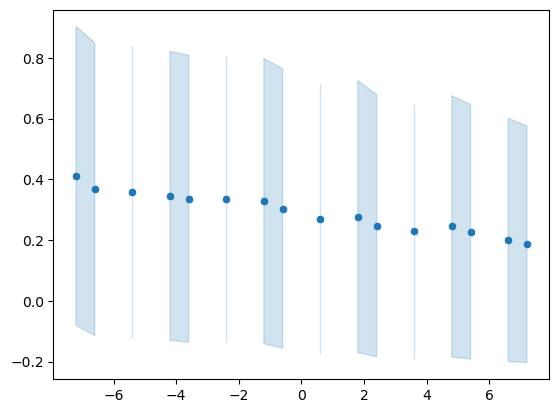

In [311]:
from scipy.stats import binned_statistic
import seaborn as sns
bins = 12*2+1
y_bins, x_edges, _ = binned_statistic(df_mortgages['qob_minus_kw'], df_mortgages['home_ownership'], statistic='mean', bins=bins)
x_bins = (x_edges[:-1] + x_edges[1:]) / 2
y_std, _, _ = binned_statistic(df_mortgages['qob_minus_kw'], df_mortgages['home_ownership'], statistic='std', bins=bins)
sns.scatterplot(x=x_bins, y=y_bins)
plt.fill_between(x_bins, y_bins-y_std, y_bins+y_std, alpha=0.2, color='C0')

In [312]:
df_mortgages['above'] = df_mortgages['qob_minus_kw']>0
controls = pd.concat(
    [
        df_mortgages['nonwhite'],
        pd.get_dummies(df_mortgages['bpl'], drop_first=True), #birthplace
        pd.get_dummies(df_mortgages['qob'], drop_first=True),
        df_mortgages['qob_minus_kw']
    ],
    axis=1
)
# we need interactions for the second stage
df_mortgages['interaction_vet'] = df_mortgages['vet_wwko']*df_mortgages['qob_minus_kw']
# and the first
df_mortgages['interaction_above'] = df_mortgages['above']*df_mortgages['qob_minus_kw']

In [313]:
model_mortgages = IV2SLS(
    df_mortgages['home_ownership'],
    controls.assign(intercept=1),
    df_mortgages[['vet_wwko', 'interaction_vet']],
    df_mortgages[['above', 'interaction_above']]
).fit()
model_mortgages.summary.tables[1]


,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
nonwhite,-0.1953,0.0095,-20.632,0.0000,-0.2139,-0.1768
Alaska,0.1695,0.1066,1.5910,0.1116,-0.0393,0.3784
Arizona,-0.0074,0.0411,-0.1799,0.8573,-0.0880,0.0732
Arkansas,0.0003,0.0213,0.0145,0.9884,-0.0415,0.0421
California,-0.0407,0.0207,-1.9691,0.0489,-0.0813,-0.0002
Colorado,-0.0216,0.0289,-0.7463,0.4555,-0.0783,0.0351
Connecticut,-0.1277,0.0278,-4.5896,0.0000,-0.1823,-0.0732
Delaware,0.0993,0.0563,1.7638,0.0778,-0.0111,0.2097
District of Columbia,-0.0963,0.0359,-2.6829,0.0073,-0.1666,-0.0259
Florida,0.0387,0.0245,1.5793,0.1143,-0.0093,0.0867
